# Preprocessing data from 10X Genomics (E18 Mouse Brain and PBMC Human)

The following notebook is meant ot be run parametrized through papermill, or directly by changing variable res_name to be "PBMC" or "MSB". Please download the data from the links below prior to running. 

Note that:

- for Mouse Brain (MSB): the single-nucleus dataset does not have a filtered option, so we'll filter ourselves.
- for PBMC: the filtered options are only available for the single-cell for pseudobulks and the single-nucleus for reference. The other dataset does not have a filtered option, so we'll filter ourselves.

## Mouse (MSB) data downloaded from:

[Single-Nucleus for Reference](https://www.10xgenomics.com/datasets/5-k-mouse-e-18-combined-cortex-hippocampus-and-subventricular-zone-nuclei-3-1-standard-6-0-0), 
[Single-Cell for Reference](https://www.10xgenomics.com/datasets/9-k-brain-cells-from-an-e-18-mouse-2-standard-2-0-1), 
[Single-Cell for Pseudo-bulks](https://www.10xgenomics.com/datasets/10-k-brain-cells-from-an-e-18-mouse-v-3-chemistry-3-standard-3-0-0)

## PBMC data downloaded from:

[Single-Nucleus for Reference](https://www.10xgenomics.com/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0), 
[Single-Cell for Reference](https://www.10xgenomics.com/datasets/10-k-human-pbm-cs-5-v-2-0-chromium-x-2-standard-6-1-0), 
[Single-Cell for Pseudo-bulks](https://www.10xgenomics.com/datasets/8-k-pbm-cs-from-a-healthy-donor-2-standard-2-1-0)

In [35]:
# Import required libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import celltypist
from celltypist import models
import os
from anndata import AnnData, read_h5ad
from pathlib import Path

In [36]:
res_name = "MSB"

In [37]:
# Set scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor="white")

base_path = f"{os.getcwd()}/../data/{res_name}/"

scanpy==1.10.3 anndata==0.10.9 umap==0.5.3 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.9.10 pynndescent==0.5.10


In [38]:
if res_name == "MSB":
    # Paths to the downloaded datasets 
    sc_ref_path = f"{base_path}/SC_Ref/filtered_gene_bc_matrices/mm10/" 
    sc_bulk_path = f"{base_path}/SC_Pseudos/filtered_feature_bc_matrix/" 
    sn_path = f"{base_path}/SN_Ref/sample_feature_bc_matrix/" 

    # Load SC pseudo-bulk dataset 
    adata_sc_bulk = sc.read_10x_mtx(sc_bulk_path, var_names="gene_symbols")

    # Load SC reference dataset 
    adata_sc_ref = sc.read_10x_mtx(sc_ref_path, var_names="gene_symbols")

    # Load SN reference dataset
    adata_sn = sc.read_10x_mtx(sn_path, var_names="gene_symbols")

    # Model for cell assignment
    model_cell = 'Developing_Mouse_Brain.pkl'
    # to identify mitochondrial genes
    myto_str = "mt-"

    # Comprehensive mapping of original cell types to grouped categories
    cell_type_mapping = {
        "Neuron: Cortical or hippocampal glutamatergic": "Excitatory Neurons",
        "Neuron: Forebrain GABAergic": "Inhibitory Neurons",
        "Neuroblast: Neuronal intermediate progenitor": "Neuronal Progenitors",
        "Neuroblast: Forebrain glutamatergic": "Neuronal Progenitors",
        "Neuroblast: Forebrain GABAergic": "Neuronal Progenitors",
        "Neuron: Cajal-Retzius": "Excitatory Neurons",
        "Glioblast: Forebrain": "Glial Cells",
        "Glioblast: Forebrain astrocyte": "Glial Cells",
        "Glioblast: Mixed region astrocytes": "Glial Cells",
        "Glioblast: Mixed region": "Glial Cells",
        "Glioblast: PreOPC": "Glial Cells",
        "Radial glia: Dorsal forebrain": "Glial Cells",
        "Radial glia: Cortical hem": "Glial Cells",
        "Oligodendrocyte: Oligodendrocyte precursor cell": "Glial Cells",
        "Vascular: Endothelial": "Vascular Cells",
        "Vascular: Pericyte": "Vascular Cells",
        "Blood: Erythrocyte": "Erythrocyte",
        "Immune: Non-cycling microglia": "Microglia"
    }

elif res_name == "PBMC":
    # Paths to the downloaded datasets 
    sc_bulk_path = f"{base_path}/filtered_gene_bc_matrices/GRCh38/" 
    sc_ref_path = f"{base_path}/10k_PBMC_5pv2_nextgem_Chromium_X_10k_PBMC_5pv2_nextgem_Chromium_X_count_sample_feature_bc_matrix.h5"
    sn_path = f"{base_path}/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"    

    # Load SC pseudo-bulk dataset 
    adata_sc_bulk = sc.read_10x_mtx(sc_bulk_path, var_names="gene_symbols")

    # Load SC reference dataset 
    adata_sc_ref = sc.read_10x_h5(sc_ref_path)

    # Load SN reference dataset
    adata_sn = sc.read_10x_h5(sn_path)

    model_cell = 'Adult_COVID19_PBMC.pkl' #says covid but includes healthy controls.
    # to identify mitochondrial genes
    myto_str = "MT-"

    cell_type_mapping = {
    "CD4n T": "CD4 T Cells",
    "CD4m T": "CD4 T Cells",
    "CD8m T": "CD8 T Cells",
    "gd T": "Gamma Delta T Cells",
    "NK": "Natural Killer Cells",
    "B": "B Cells",
    "IgA PB": "Plasmablasts",
    "CD14 Monocyte": "CD14 Monocytes",
    "CD16 Monocyte": "CD16 Monocytes",
    "DC": "Dendritic Cells",
    "pDC": "Dendritic Cells",
    "SC & Eosinophil": "SC & Eosinophil",
    "Platelet": "Platelets"
}
else:
    ValueError(f'Not a valid res_name. Choose "MSB"" or "PBMC", you choose {res_name}')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [39]:
# Display dataset shapes
print(f"SC Bulk: {adata_sc_bulk.shape}, SC Ref: {adata_sc_ref.shape}, SN: {adata_sn.shape}")

# Make unique gene names
adata_sc_bulk.var_names_make_unique()
adata_sc_ref.var_names_make_unique()
adata_sn.var_names_make_unique()

# Quick QC summary
adata_list = [adata_sc_bulk, adata_sc_ref, adata_sn]
for i, adata in enumerate(adata_list):
    print(f"Dataset {i+1}: {adata.shape} cells x genes")

# View raw counts matrix to check for any abnormalities/normalizations
adata_sc_bulk.X[:5, :5]

SC Bulk: (11843, 31053), SC Ref: (9128, 27998), SN: (5973, 32285)
Dataset 1: (11843, 31053) cells x genes
Dataset 2: (9128, 27998) cells x genes
Dataset 3: (5973, 32285) cells x genes


<5x5 sparse matrix of type '<class 'numpy.float32'>'
	with 0 stored elements in Compressed Sparse Column format>

In [40]:
# Compute basic QC metrics
for adata in adata_list:
    adata.var["mt"] = adata.var_names.str.startswith(myto_str)  # Mitochondrial genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

## Plot QC metrics and filter accordingly

In [41]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.3 anndata==0.10.9 umap==0.5.3 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.9.10 pynndescent==0.5.10


... storing 'feature_types' as categorical


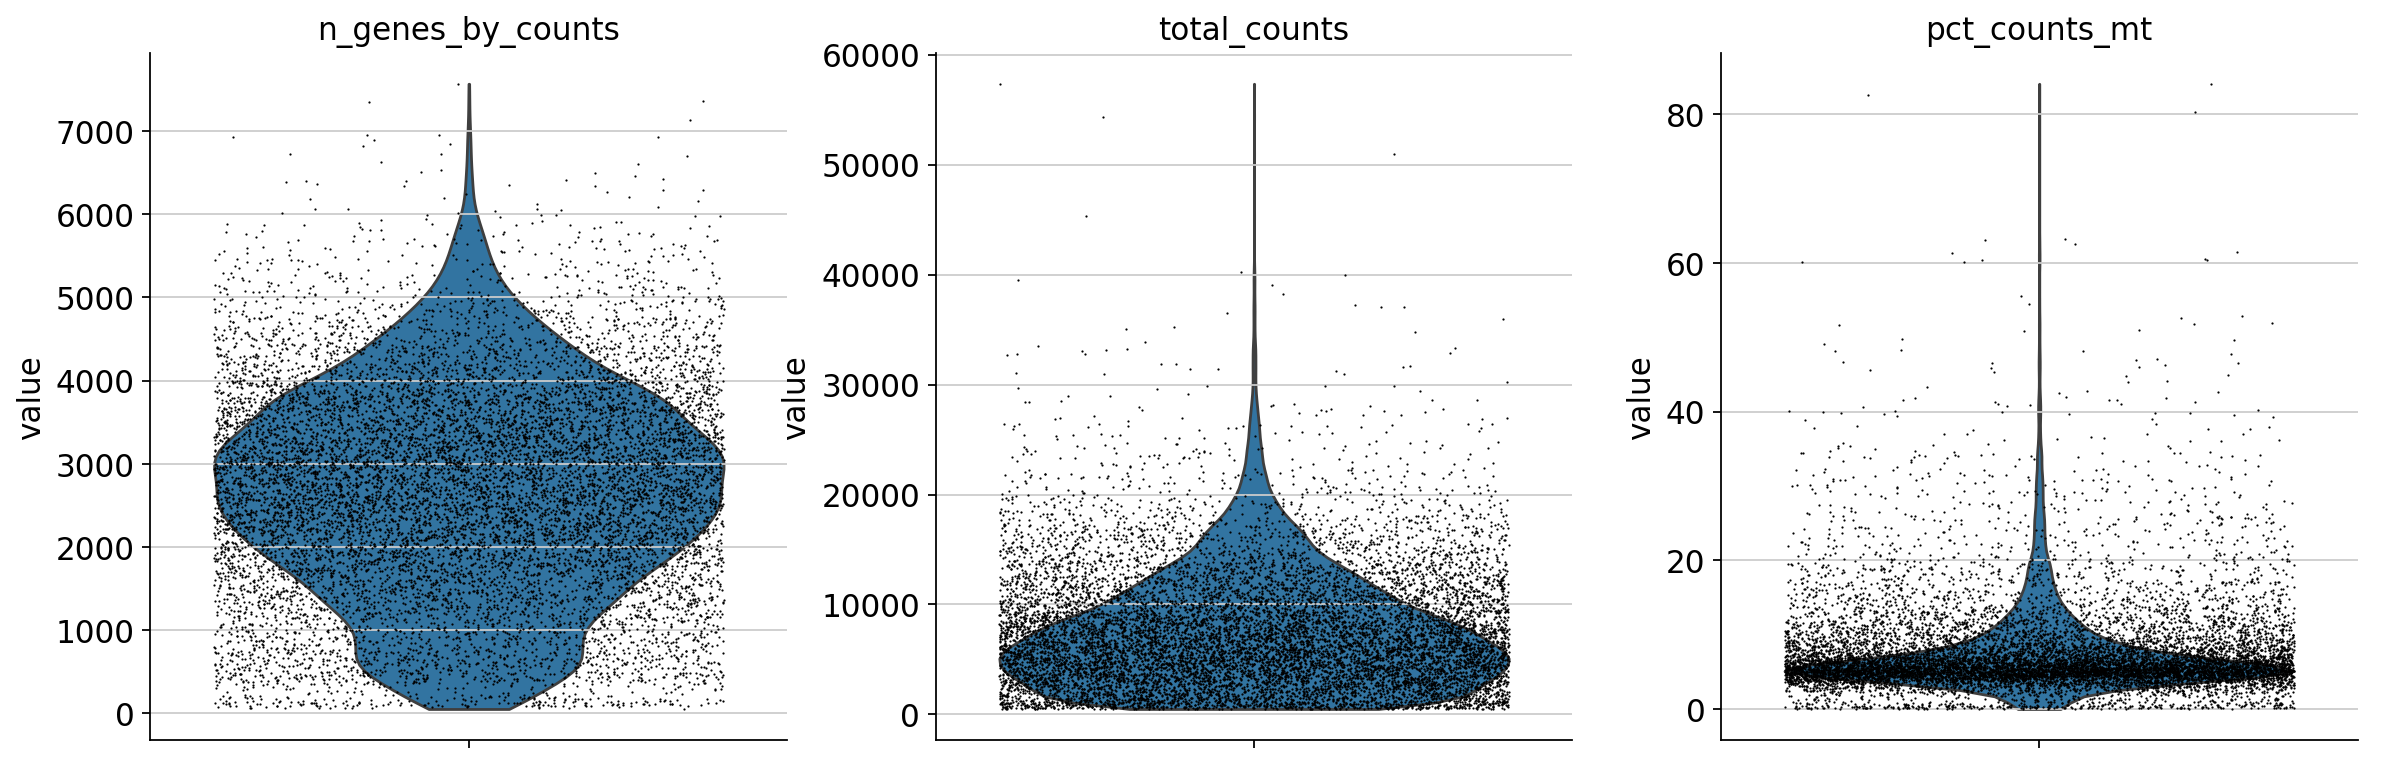

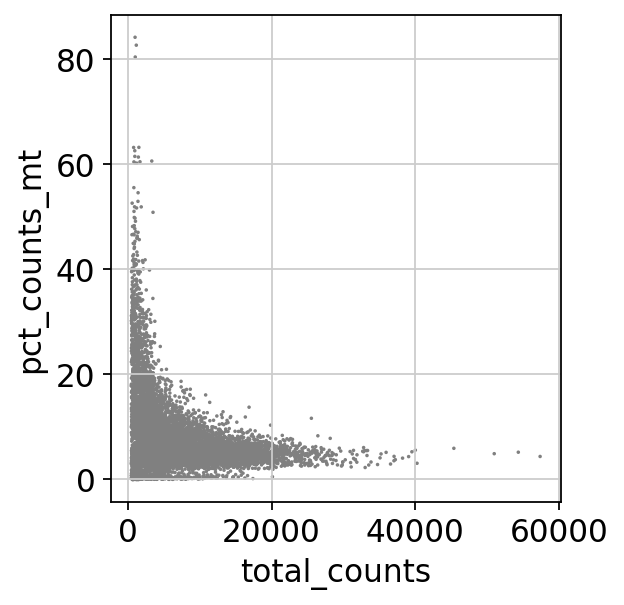

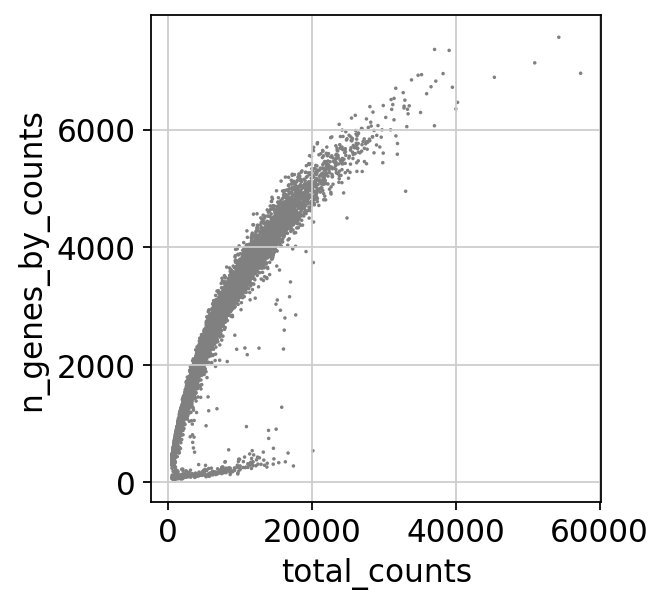

In [42]:
sc.pl.violin(adata_sc_bulk, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_sc_bulk, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_sc_bulk, x='total_counts', y='n_genes_by_counts')

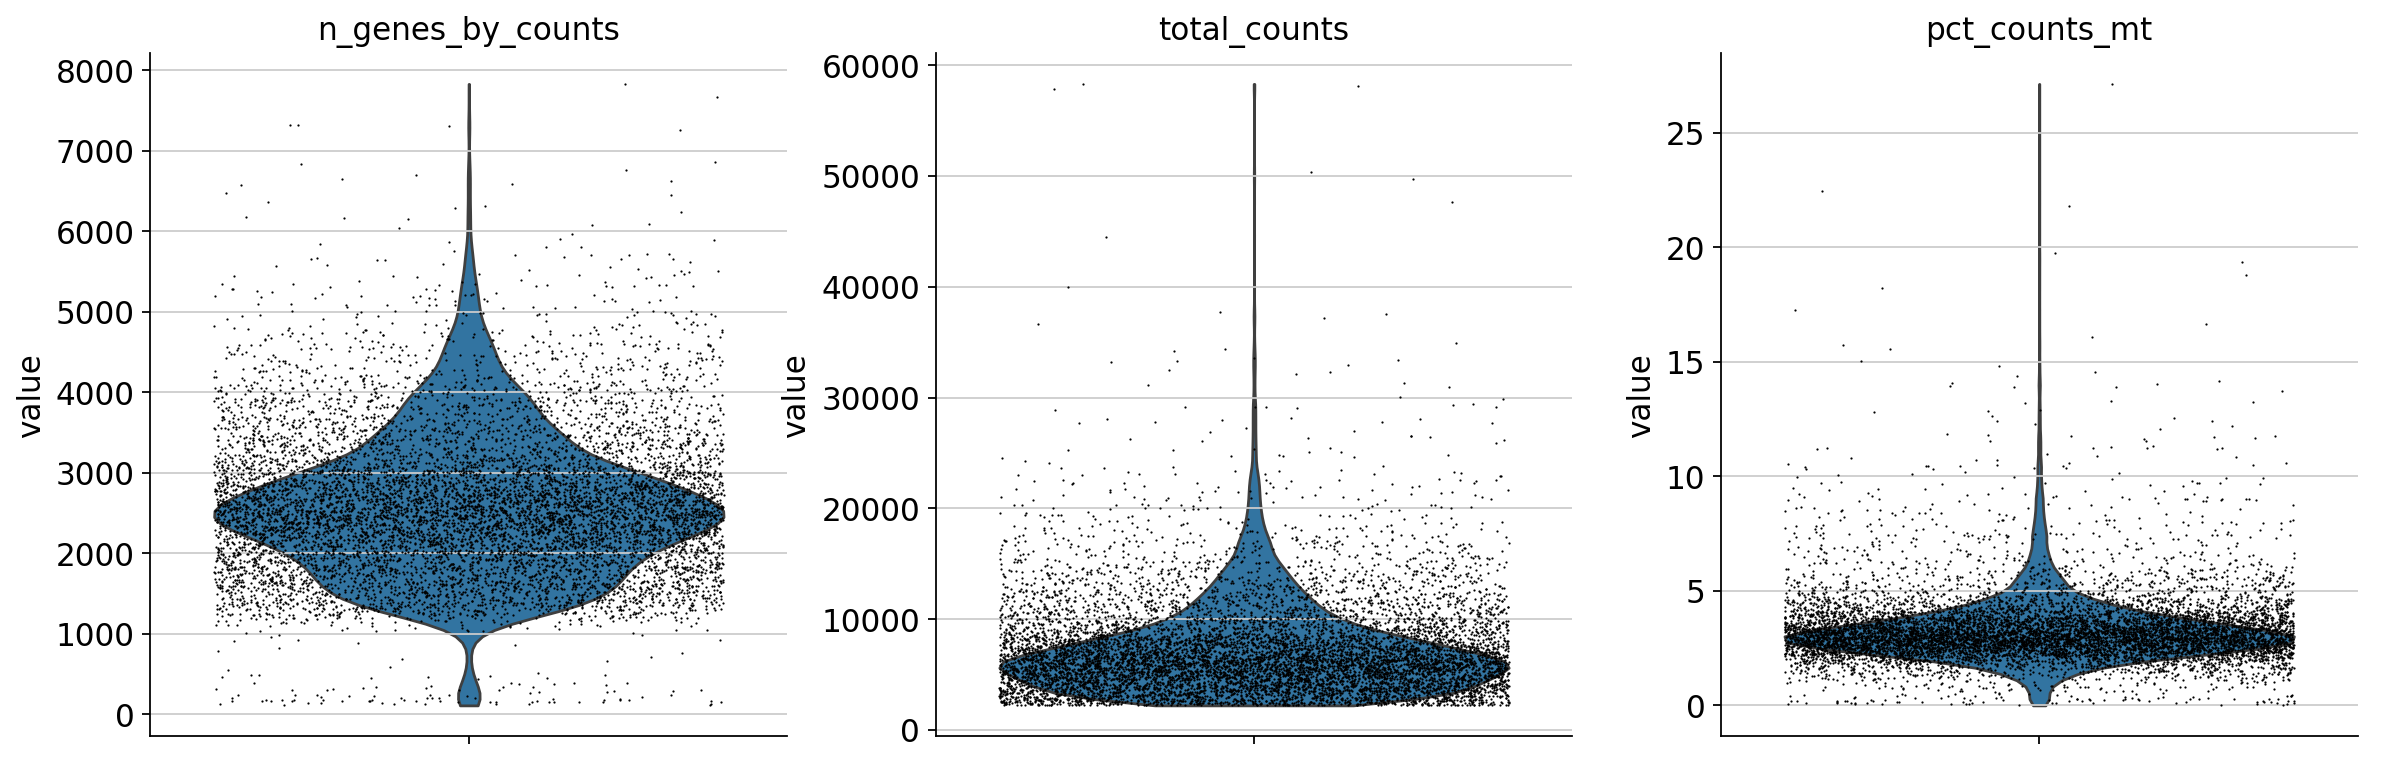

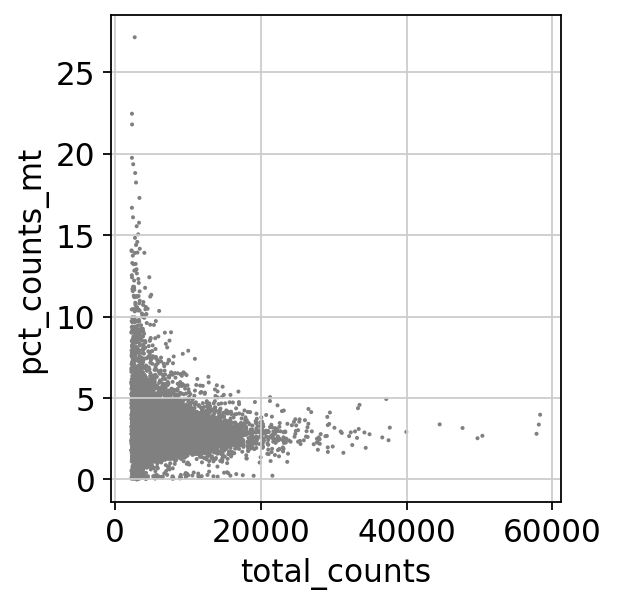

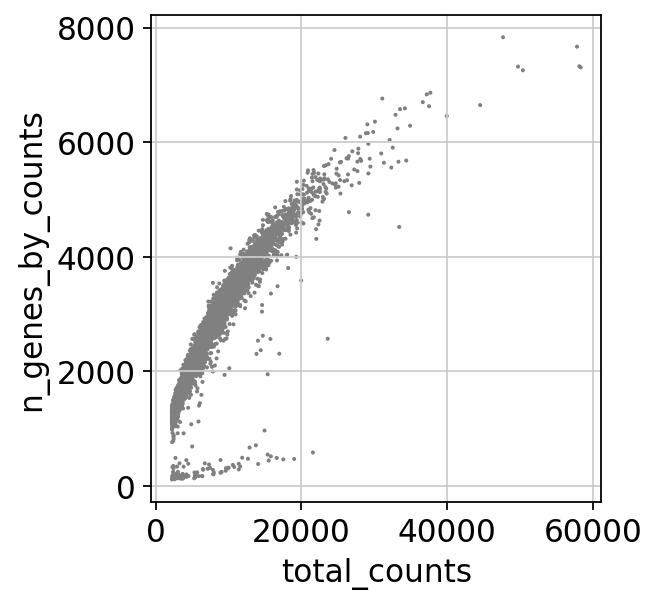

In [43]:
sc.pl.violin(adata_sc_ref, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_sc_ref, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_sc_ref, x='total_counts', y='n_genes_by_counts')

... storing 'feature_types' as categorical


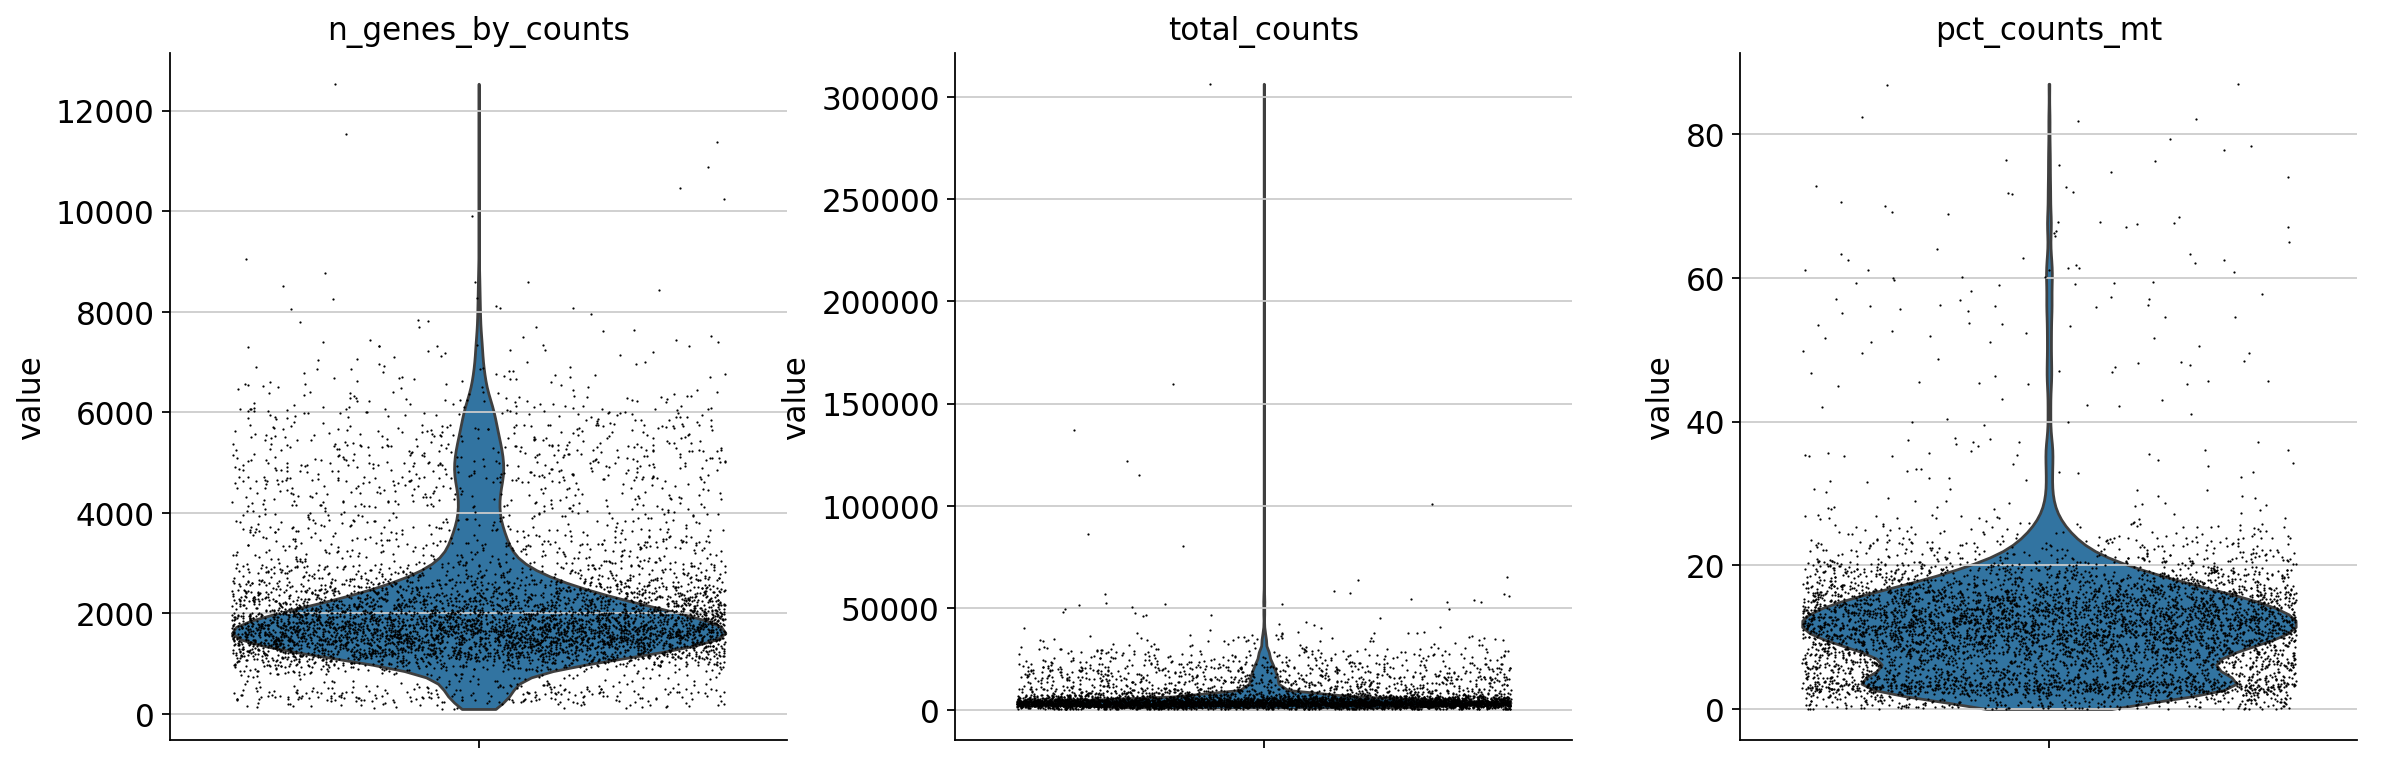

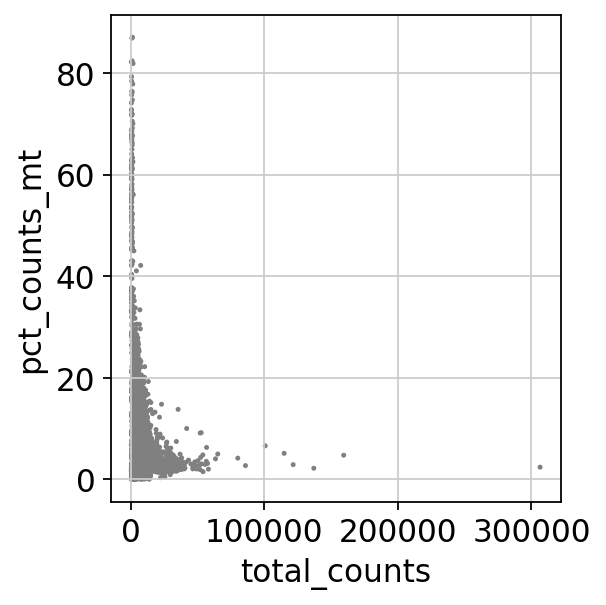

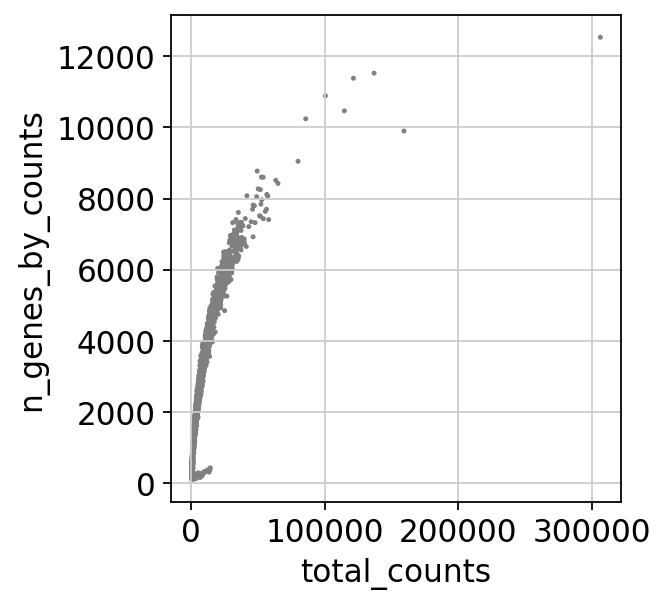

In [44]:
sc.pl.violin(adata_sn, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_sn, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_sn, x='total_counts', y='n_genes_by_counts')

We'll filter the datasets as needed after!

## Dimensionality Reduction (PCA & UMAP and clustering)

In [45]:
for adata in adata_list:
    adata.raw = adata.copy()

In [46]:
# Normalize each dataset
for adata in adata_list:
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize total read counts per cell
    sc.pp.log1p(adata)  # Log transformation

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [47]:
for adata in adata_list:
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


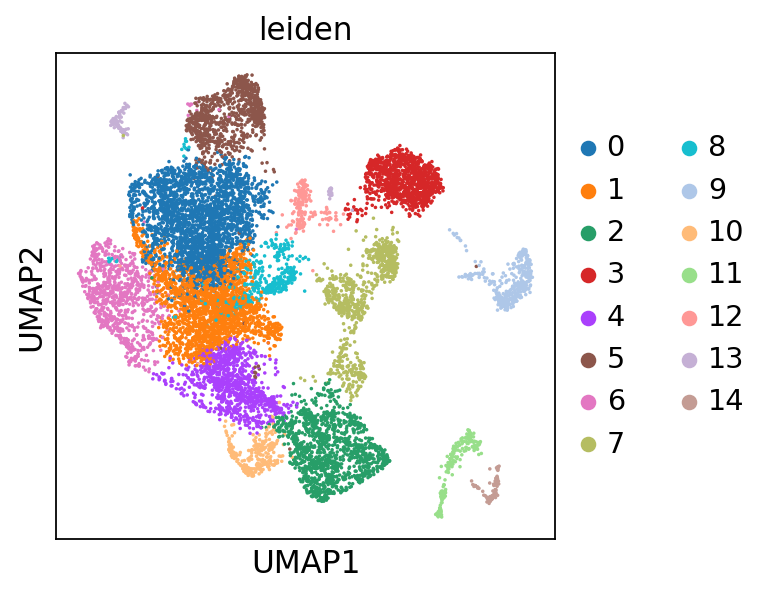

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


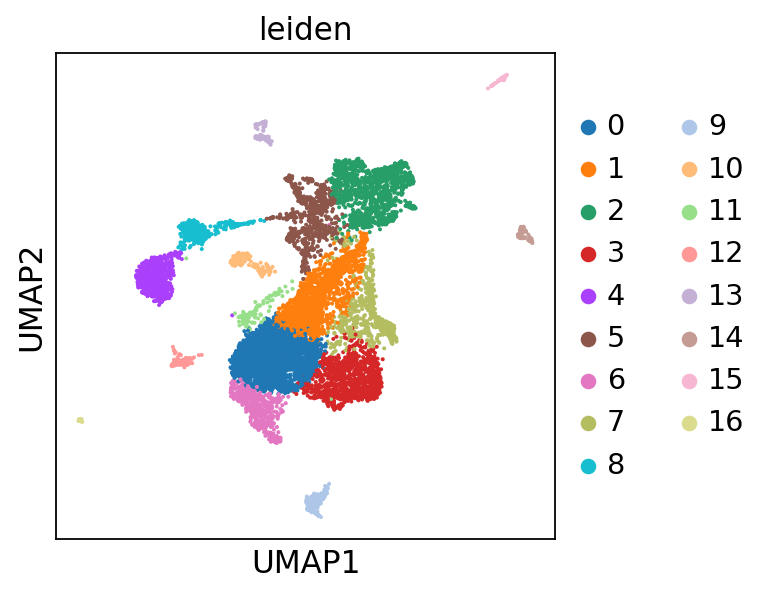

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


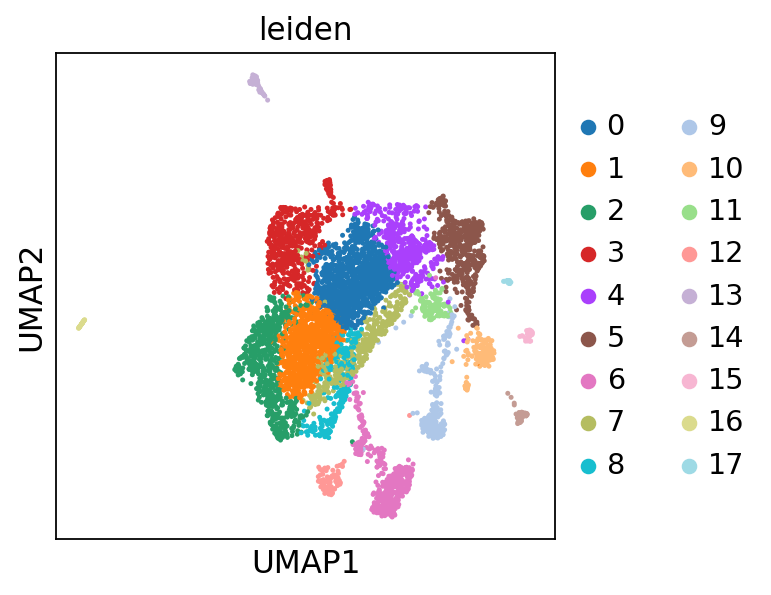

In [48]:
for adata in adata_list:
    sc.tl.leiden(adata, resolution=0.5)  # Louvain clustering
    sc.pl.umap(adata, color="leiden")

## Assigning with celltypist, following this [tutorial](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb#scrollTo=premier-measurement)

In [49]:
models.models_path = base_path
models.download_models(model = model_cell, force_update = True)  # Enabling `force_update = True` will overwrite existing (old) models.
models.models_description()

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /projects/aivich@xsede.org/deconvolution_differences/notebooks/../data/MSB/
💾 Total models to download: 1
💾 Downloading model [1/1]: Developing_Mouse_Brain.pkl
👉 Detailed model information can be found at `https://www.celltypist.org/models`


model  \
0                        Immune_All_Low.pkl   
1                       Immune_All_High.pkl   
2                    Adult_COVID19_PBMC.pkl   
3   Adult_CynomolgusMacaque_Hippocampus.pkl   
4                       Adult_Human_MTG.pkl   
5           Adult_Human_PancreaticIslet.pkl   
6          Adult_Human_PrefrontalCortex.pkl   
7                      Adult_Human_Skin.pkl   
8                  Adult_Human_Vascular.pkl   
9                       Adult_Mouse_Gut.pkl   
10            Adult_Mouse_OlfactoryBulb.pkl   
11                Adult_Pig_Hippocampus.pkl   
12      Adult_RhesusMacaque_Hippocampus.pkl   
13                 Autopsy_COVID19_Lung.pkl   
14         COVID19_HumanChallenge_Blood.pkl   
15             COVID19_Immune_Landscape.pkl   
16                   Cells_Adult_Breast.pkl   
17                     Cells_Fetal_Lung.pkl   
18                   Cells_Human_Tonsil.pkl   
19               Cells_Intestinal_Tract.pkl   
20                    Cells_Lung_Airway.pkl   
21               Developing_Human_Brain.pkl   
22              Developing_Human_Gonads.pkl   
23         Developing_Human_Hippocampus.pkl   
24              Developing_Human_Organs.pkl   
25              Developing_Human_Thymus.pkl   
26               Developing_Mouse_Brain.pkl   
27         Developing_Mouse_Hippocampus.pkl   
28            Fetal_Human_AdrenalGlands.pkl   
29                 Fetal_Human_Pancreas.pkl   
30                Fetal_Human_Pituitary.pkl   
31                   Fetal_Human_Retina.pkl   
32                     Fetal_Human_Skin.pkl   
33                  Healthy_Adult_Heart.pkl   
34                 Healthy_COVID19_PBMC.pkl   
35                  Healthy_Human_Liver.pkl   
36                  Healthy_Mouse_Liver.pkl   
37          Human_AdultAged_Hippocampus.pkl   
38              Human_Colorectal_Cancer.pkl   
39           Human_Developmental_Retina.pkl   
40              Human_Embryonic_YolkSac.pkl   
41              Human_Endometrium_Atlas.pkl   
42                       Human_IPF_Lung.pkl   
43       Human_Longitudinal_Hippocampus.pkl   
44                     Human_Lung_Atlas.pkl   
45                        Human_PF_Lung.pkl   
46               Human_Placenta_Decidua.pkl   
47                  Lethal_COVID19_Lung.pkl   
48                  Mouse_Dentate_Gyrus.pkl   
49          Mouse_Isocortex_Hippocampus.pkl   
50         Mouse_Postnatal_DentateGyrus.pkl   
51                    Mouse_Whole_Brain.pkl   
52                   Nuclei_Lung_Airway.pkl   
53                      Pan_Fetal_Human.pkl   

                                          description  
0   immune sub-populations combined from 20 tissue...  
1   immune populations combined from 20 tissues of...  
2   peripheral blood mononuclear cell types from C...  
3   cell types from the hippocampus of adult cynom...  
4   cell types and subtypes (10x-based) from the a...  
5   cell types from pancreatic islets of healthy a...  
6   cell types and subtypes from the adult human d...  
7            cell types from human healthy adult skin  
8   vascular populations combined from multiple ad...  
9   cell types in the adult mouse gut combined fro...  
10   cell types from the olfactory bulb of adult mice  
11          cell types from the adult pig hippocampus  
12  cell types from the hippocampus of adult rhesu...  
13  cell types from the lungs of 16 SARS-CoV-2 inf...  
14  detailed blood cell states from 16 individuals...  
15  immune subtypes from lung and blood of COVID-1...  
16             cell types from the adult human breast  
17    cell types from human embryonic and fetal lungs  
18      tonsillar cell types from humans (3-65 years)  
19  intestinal cells from fetal, pediatric (health...  
20  cell populations from scRNA-seq of five locati...  
21  cell types from the first-trimester developing...  
22  cell types of human gonadal and adjacent extra...  
23   cell types from the developing human hippocampus  
24  cell types of five endoderm-derived organs in ..

In [50]:
# Load model and predict
predictions_sn = celltypist.annotate(adata_sn, model = model_cell, majority_voting = True)
predictions_sn.predicted_labels.majority_voting.value_counts()

🔬 Input data has 5973 cells and 32285 genes
🔗 Matching reference genes in the model
🧬 7326 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 102 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


majority_voting
Neuron: Cortical or hippocampal glutamatergic      3653
Neuroblast: Neuronal intermediate progenitor        759
Blood: Erythrocyte                                  482
Neuron: Forebrain GABAergic                         464
Glioblast: Forebrain                                322
Neuron: Cajal-Retzius                                50
Neuroblast: Forebrain GABAergic                      45
Vascular: Pericyte                                   45
Radial glia: Dorsal forebrain                        40
Vascular: Endothelial                                39
Neuroblast: Forebrain glutamatergic                  30
Immune: Non-cycling microglia                        27
Oligodendrocyte: Oligodendrocyte precursor cell      17
Name: count, dtype: int64

In [51]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
predictions_sn.predicted_labels
adata_sn = predictions_sn.to_adata()
adata_sn.obs["cell_types"] = adata_sn.obs["predicted_labels"]
adata_sn.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGGCTGAAC-1               2563        6666.0            551.0   
AAACCCAAGTTGGAAT-1               3375        8399.0            455.0   
AAACCCACAATTGCTG-1               4121       10679.0            690.0   
AAACCCACAGAGTCTT-1               1529        3024.0            376.0   
AAACCCAGTCTTCCGT-1               2886        7421.0            625.0   
...                               ...           ...              ...   
TTTGTTGAGTAATACG-1               1599        3270.0            585.0   
TTTGTTGCACGCCACA-1               2815        7002.0            720.0   
TTTGTTGGTATAATGG-1               1737        3446.0            318.0   
TTTGTTGGTCCGATCG-1               2058        4240.0            502.0   
TTTGTTGTCGCGCCAA-1               1900        3992.0            105.0   

                    pct_counts_mt leiden  \
AAACCCAAGGCTGAAC-1       8.265827      3   
AAACCCAAGTTGGAAT-1       5.417312      7   
AAACCCACAATTGCTG-1       6.461279     14   
AAACCCACAGAGTCTT-1      12.433863      2   
AAACCCAGTCTTCCGT-1       8.422046      1   
...                           ...    ...   
TTTGTTGAGTAATACG-1      17.889908      0   
TTTGTTGCACGCCACA-1      10.282777      2   
TTTGTTGGTATAATGG-1       9.228090      2   
TTTGTTGGTCCGATCG-1      11.839623      1   
TTTGTTGTCGCGCCAA-1       2.630260      2   

                                                 predicted_labels  \
AAACCCAAGGCTGAAC-1  Neuron: Cortical or hippocampal glutamatergic   
AAACCCAAGTTGGAAT-1  Neuron: Cortical or hippocampal glutamatergic   
AAACCCACAATTGCTG-1                             Vascular: Pericyte   
AAACCCACAGAGTCTT-1  Neuron: Cortical or hippocampal glutamatergic   
AAACCCAGTCTTCCGT-1  Neuron: Cortical or hippocampal glutamatergic   
...                                                           ...   
TTTGTTGAGTAATACG-1                             Blood: Erythrocyte   
TTTGTTGCACGCCACA-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTTGGTATAATGG-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTTGGTCCGATCG-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTTGTCGCGCCAA-1  Neuron: Cortical or hippocampal glutamatergic   

                   over_clustering  \
AAACCCAAGGCTGAAC-1              94   
AAACCCAAGTTGGAAT-1              42   
AAACCCACAATTGCTG-1              67   
AAACCCACAGAGTCTT-1              77   
AAACCCAGTCTTCCGT-1              20   
...                            ...   
TTTGTTGAGTAATACG-1              39   
TTTGTTGCACGCCACA-1              53   
TTTGTTGGTATAATGG-1               2   
TTTGTTGGTCCGATCG-1              51   
TTTGTTGTCGCGCCAA-1              34   

                                                  majority_voting  conf_score  \
AAACCCAAGGCTGAAC-1  Neuron: Cortical or hippocampal glutamatergic    0.999993   
AAACCCAAGTTGGAAT-1  Neuron: Cortical or hippocampal glutamatergic    0.980929   
AAACCCACAATTGCTG-1                             Vascular: Pericyte    0.999974   
AAACCCACAGAGTCTT-1  Neuron: Cortical or hippocampal glutamatergic    0.998026   
AAACCCAGTCTTCCGT-1  Neuron: Cortical or hippocampal glutamatergic    0.999979   
...                                                           ...         ...   
TTTGTTGAGTAATACG-1  Neuron: Cortical or hippocampal glutamatergic    0.694193   
TTTGTTGCACGCCACA-1  Neuron: Cortical or hippocampal glutamatergic    0.999968   
TTTGTTGGTATAATGG-1  Neuron: Cortical or hippocampal glutamatergic    0.998946   
TTTGTTGGTCCGATCG-1  Neuron: Cortical or hippocampal glutamatergic    0.999723   
TTTGTTGTCGCGCCAA-1  Neuron: Cortical or hippocampal glutamatergic    0.999031   

                                                       cell_types  
AAACCCAAGGCTGAAC-1  Neuron: Cortical or hippocampal glutamatergic  
AAACCCAAGTTGGAAT-1  Neuron: Cortical or hippocampal glutamatergic  
AAACCCACAATTGCTG-1                             Vascular: Pericyte  
AAACCCACAGAGTCTT-1  Neuron: Cortical or hippocampal glutamatergic  
AAACCCAGTCTTCCGT-1  Neuron:

In [52]:
# Load model and predict
predictions_sc = celltypist.annotate(adata_sc_ref, model = model_cell, majority_voting = True)
predictions_sc.predicted_labels.majority_voting.value_counts()

🔬 Input data has 9128 cells and 27998 genes
🔗 Matching reference genes in the model
🧬 7207 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 111 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:01)


🗳️ Majority voting the predictions
✅ Majority voting done!


majority_voting
Neuron: Cortical or hippocampal glutamatergic      4926
Neuron: Forebrain GABAergic                        1179
Neuroblast: Neuronal intermediate progenitor       1148
Glioblast: Forebrain                                465
Neuroblast: Forebrain glutamatergic                 183
Neuron: Cajal-Retzius                               172
Radial glia: Dorsal forebrain                       165
Glioblast: Forebrain astrocyte                      129
Neuroblast: Forebrain GABAergic                     123
Glioblast: Mixed region astrocytes                  103
Blood: Erythrocyte                                   95
Vascular: Endothelial                                84
Oligodendrocyte: Oligodendrocyte precursor cell      67
Vascular: Pericyte                                   65
Glioblast: PreOPC                                    60
Blood: Undefined                                     48
Immune: Non-cycling microglia                        48
Radial glia: Cortical hem       

In [53]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
predictions_sc.predicted_labels
adata_sc_ref = predictions_sc.to_adata()
adata_sc_ref.obs["cell_types"] = adata_sc_ref.obs["predicted_labels"]
adata_sc_ref.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGACGCTTT-1               1467        3171.0            208.0   
AAACCTGAGATCTGCT-1               3127        8936.0            294.0   
AAACCTGAGGTCATCT-1               1367        2853.0             85.0   
AAACCTGCAAGAGTCG-1               2595        7575.0            323.0   
AAACCTGCACACATGT-1               4034       18053.0            657.0   
...                               ...           ...              ...   
TTTGTCAGTCTTGATG-1               2613        7633.0            279.0   
TTTGTCAGTGATAAAC-1               2629        6638.0            184.0   
TTTGTCATCCTTGACC-1               4719       18660.0            511.0   
TTTGTCATCGGCTACG-1               1784        3796.0            109.0   
TTTGTCATCGTCCGTT-1               3053        8592.0            339.0   

                    pct_counts_mt leiden  \
AAACCTGAGACGCTTT-1       6.559445      5   
AAACCTGAGATCTGCT-1       3.290063      3   
AAACCTGAGGTCATCT-1       2.979320      8   
AAACCTGCAAGAGTCG-1       4.264027      6   
AAACCTGCACACATGT-1       3.639284      2   
...                           ...    ...   
TTTGTCAGTCTTGATG-1       3.655181      0   
TTTGTCAGTGATAAAC-1       2.771919      0   
TTTGTCATCCTTGACC-1       2.738478      0   
TTTGTCATCGGCTACG-1       2.871444      6   
TTTGTCATCGTCCGTT-1       3.945531      3   

                                                 predicted_labels  \
AAACCTGAGACGCTTT-1   Neuroblast: Neuronal intermediate progenitor   
AAACCTGAGATCTGCT-1  Neuron: Cortical or hippocampal glutamatergic   
AAACCTGAGGTCATCT-1                    Neuron: Forebrain GABAergic   
AAACCTGCAAGAGTCG-1  Neuron: Cortical or hippocampal glutamatergic   
AAACCTGCACACATGT-1                        Glioblast: Mixed region   
...                                                           ...   
TTTGTCAGTCTTGATG-1                    Neuron: Forebrain GABAergic   
TTTGTCAGTGATAAAC-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTCATCCTTGACC-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTCATCGGCTACG-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTCATCGTCCGTT-1  Neuron: Cortical or hippocampal glutamatergic   

                   over_clustering  \
AAACCTGAGACGCTTT-1              23   
AAACCTGAGATCTGCT-1              39   
AAACCTGAGGTCATCT-1               1   
AAACCTGCAAGAGTCG-1              20   
AAACCTGCACACATGT-1              29   
...                            ...   
TTTGTCAGTCTTGATG-1              22   
TTTGTCAGTGATAAAC-1              43   
TTTGTCATCCTTGACC-1              54   
TTTGTCATCGGCTACG-1              60   
TTTGTCATCGTCCGTT-1              13   

                                                  majority_voting  conf_score  \
AAACCTGAGACGCTTT-1   Neuroblast: Neuronal intermediate progenitor    0.984553   
AAACCTGAGATCTGCT-1  Neuron: Cortical or hippocampal glutamatergic    0.984301   
AAACCTGAGGTCATCT-1                    Neuron: Forebrain GABAergic    0.998193   
AAACCTGCAAGAGTCG-1  Neuron: Cortical or hippocampal glutamatergic    0.999621   
AAACCTGCACACATGT-1             Glioblast: Mixed region astrocytes    0.461135   
...                                                           ...         ...   
TTTGTCAGTCTTGATG-1  Neuron: Cortical or hippocampal glutamatergic    0.403126   
TTTGTCAGTGATAAAC-1  Neuron: Cortical or hippocampal glutamatergic    0.984270   
TTTGTCATCCTTGACC-1  Neuron: Cortical or hippocampal glutamatergic    0.999879   
TTTGTCATCGGCTACG-1  Neuron: Cortical or hippocampal glutamatergic    0.999316   
TTTGTCATCGTCCGTT-1  Neuron: Cortical or hippocampal glutamatergic    0.996920   

                                                       cell_types  
AAACCTGAGACGCTTT-1   Neuroblast: Neuronal intermediate progenitor  
AAACCTGAGATCTGCT-1  Neuron: Cortical or hippocampal glutamatergic  
AAACCTGAGGTCATCT-1                    Neuron: Forebrain GABAergic  
AAACCTGCAAGAGTCG-1  Neuron: Cortical or hippocampal glutamatergic  
AAACCTGCACACATGT-1         

In [54]:
predictions_pseudo = celltypist.annotate(adata_sc_bulk, model = model_cell, majority_voting = True)
predictions_pseudo.predicted_labels.majority_voting.value_counts()

🔬 Input data has 11843 cells and 31053 genes
🔗 Matching reference genes in the model
🧬 7416 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 113 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:01)


🗳️ Majority voting the predictions
✅ Majority voting done!


majority_voting
Neuron: Cortical or hippocampal glutamatergic      6512
Neuron: Forebrain GABAergic                        1800
Neuroblast: Neuronal intermediate progenitor       1444
Glioblast: Forebrain                                698
Blood: Erythrocyte                                  396
Neuroblast: Forebrain glutamatergic                 263
Vascular: Endothelial                               125
Neuroblast: Forebrain GABAergic                     111
Neuron: Cajal-Retzius                               110
Glioblast: Mixed region                              99
Vascular: Pericyte                                   86
Radial glia: Dorsal forebrain                        69
Oligodendrocyte: Oligodendrocyte precursor cell      66
Immune: Non-cycling microglia                        64
Name: count, dtype: int64

In [55]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
predictions_pseudo.predicted_labels
adata_sc_bulk = predictions_pseudo.to_adata()
adata_sc_bulk.obs["cell_types"] = adata_sc_bulk.obs["predicted_labels"]
adata_sc_bulk.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCAAGCAACTCT-1                784        1421.0              3.0   
AAACCCACACGCGGTT-1               2400        5833.0            698.0   
AAACCCACAGCATACT-1               1776        2978.0            362.0   
AAACCCACATACCATG-1               1934        3599.0            238.0   
AAACCCAGTCGCACAC-1               3473        9152.0            452.0   
...                               ...           ...              ...   
TTTGTTGGTAGCTAAA-1               3439        9756.0            388.0   
TTTGTTGGTATCCCAA-1               1987        4231.0            485.0   
TTTGTTGGTCCGAAAG-1               1404        2415.0             72.0   
TTTGTTGGTTCAACGT-1               2529        6103.0            341.0   
TTTGTTGTCCGTTTCG-1               2322        4163.0            293.0   

                    pct_counts_mt leiden  \
AAACCCAAGCAACTCT-1       0.211119      2   
AAACCCACACGCGGTT-1      11.966398      1   
AAACCCACAGCATACT-1      12.155809      2   
AAACCCACATACCATG-1       6.612948      3   
AAACCCAGTCGCACAC-1       4.938811      4   
...                           ...    ...   
TTTGTTGGTAGCTAAA-1       3.977040      0   
TTTGTTGGTATCCCAA-1      11.463011      1   
TTTGTTGGTCCGAAAG-1       2.981366      0   
TTTGTTGGTTCAACGT-1       5.587416      1   
TTTGTTGTCCGTTTCG-1       7.038194      5   

                                                 predicted_labels  \
AAACCCAAGCAACTCT-1                           Glioblast: Forebrain   
AAACCCACACGCGGTT-1  Neuron: Cortical or hippocampal glutamatergic   
AAACCCACAGCATACT-1                           Glioblast: Forebrain   
AAACCCACATACCATG-1                    Neuron: Forebrain GABAergic   
AAACCCAGTCGCACAC-1   Neuroblast: Neuronal intermediate progenitor   
...                                                           ...   
TTTGTTGGTAGCTAAA-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTTGGTATCCCAA-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTTGGTCCGAAAG-1  Neuron: Cortical or hippocampal glutamatergic   
TTTGTTGGTTCAACGT-1            Neuroblast: Forebrain glutamatergic   
TTTGTTGTCCGTTTCG-1  Neuron: Cortical or hippocampal glutamatergic   

                   over_clustering  \
AAACCCAAGCAACTCT-1              50   
AAACCCACACGCGGTT-1              88   
AAACCCACAGCATACT-1              32   
AAACCCACATACCATG-1               4   
AAACCCAGTCGCACAC-1              74   
...                            ...   
TTTGTTGGTAGCTAAA-1              39   
TTTGTTGGTATCCCAA-1              88   
TTTGTTGGTCCGAAAG-1              30   
TTTGTTGGTTCAACGT-1              15   
TTTGTTGTCCGTTTCG-1               5   

                                                  majority_voting  conf_score  \
AAACCCAAGCAACTCT-1                           Glioblast: Forebrain    0.632753   
AAACCCACACGCGGTT-1  Neuron: Cortical or hippocampal glutamatergic    0.865804   
AAACCCACAGCATACT-1                           Glioblast: Forebrain    0.399061   
AAACCCACATACCATG-1                    Neuron: Forebrain GABAergic    0.999948   
AAACCCAGTCGCACAC-1   Neuroblast: Neuronal intermediate progenitor    0.977629   
...                                                           ...         ...   
TTTGTTGGTAGCTAAA-1  Neuron: Cortical or hippocampal glutamatergic    0.995103   
TTTGTTGGTATCCCAA-1  Neuron: Cortical or hippocampal glutamatergic    0.257471   
TTTGTTGGTCCGAAAG-1  Neuron: Cortical or hippocampal glutamatergic    0.694055   
TTTGTTGGTTCAACGT-1   Neuroblast: Neuronal intermediate progenitor    0.602218   
TTTGTTGTCCGTTTCG-1  Neuron: Cortical or hippocampal glutamatergic    0.999999   

                                                       cell_types  
AAACCCAAGCAACTCT-1                           Glioblast: Forebrain  
AAACCCACACGCGGTT-1  Neuron: Cortical or hippocampal glutamatergic  
AAACCCACAGCATACT-1                           Glioblast: Forebrain  
AAACCCACATACCATG-1                    Neuron: Forebrain GABAergic  
AAACCCAGTCGCACAC-1   Neurob

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


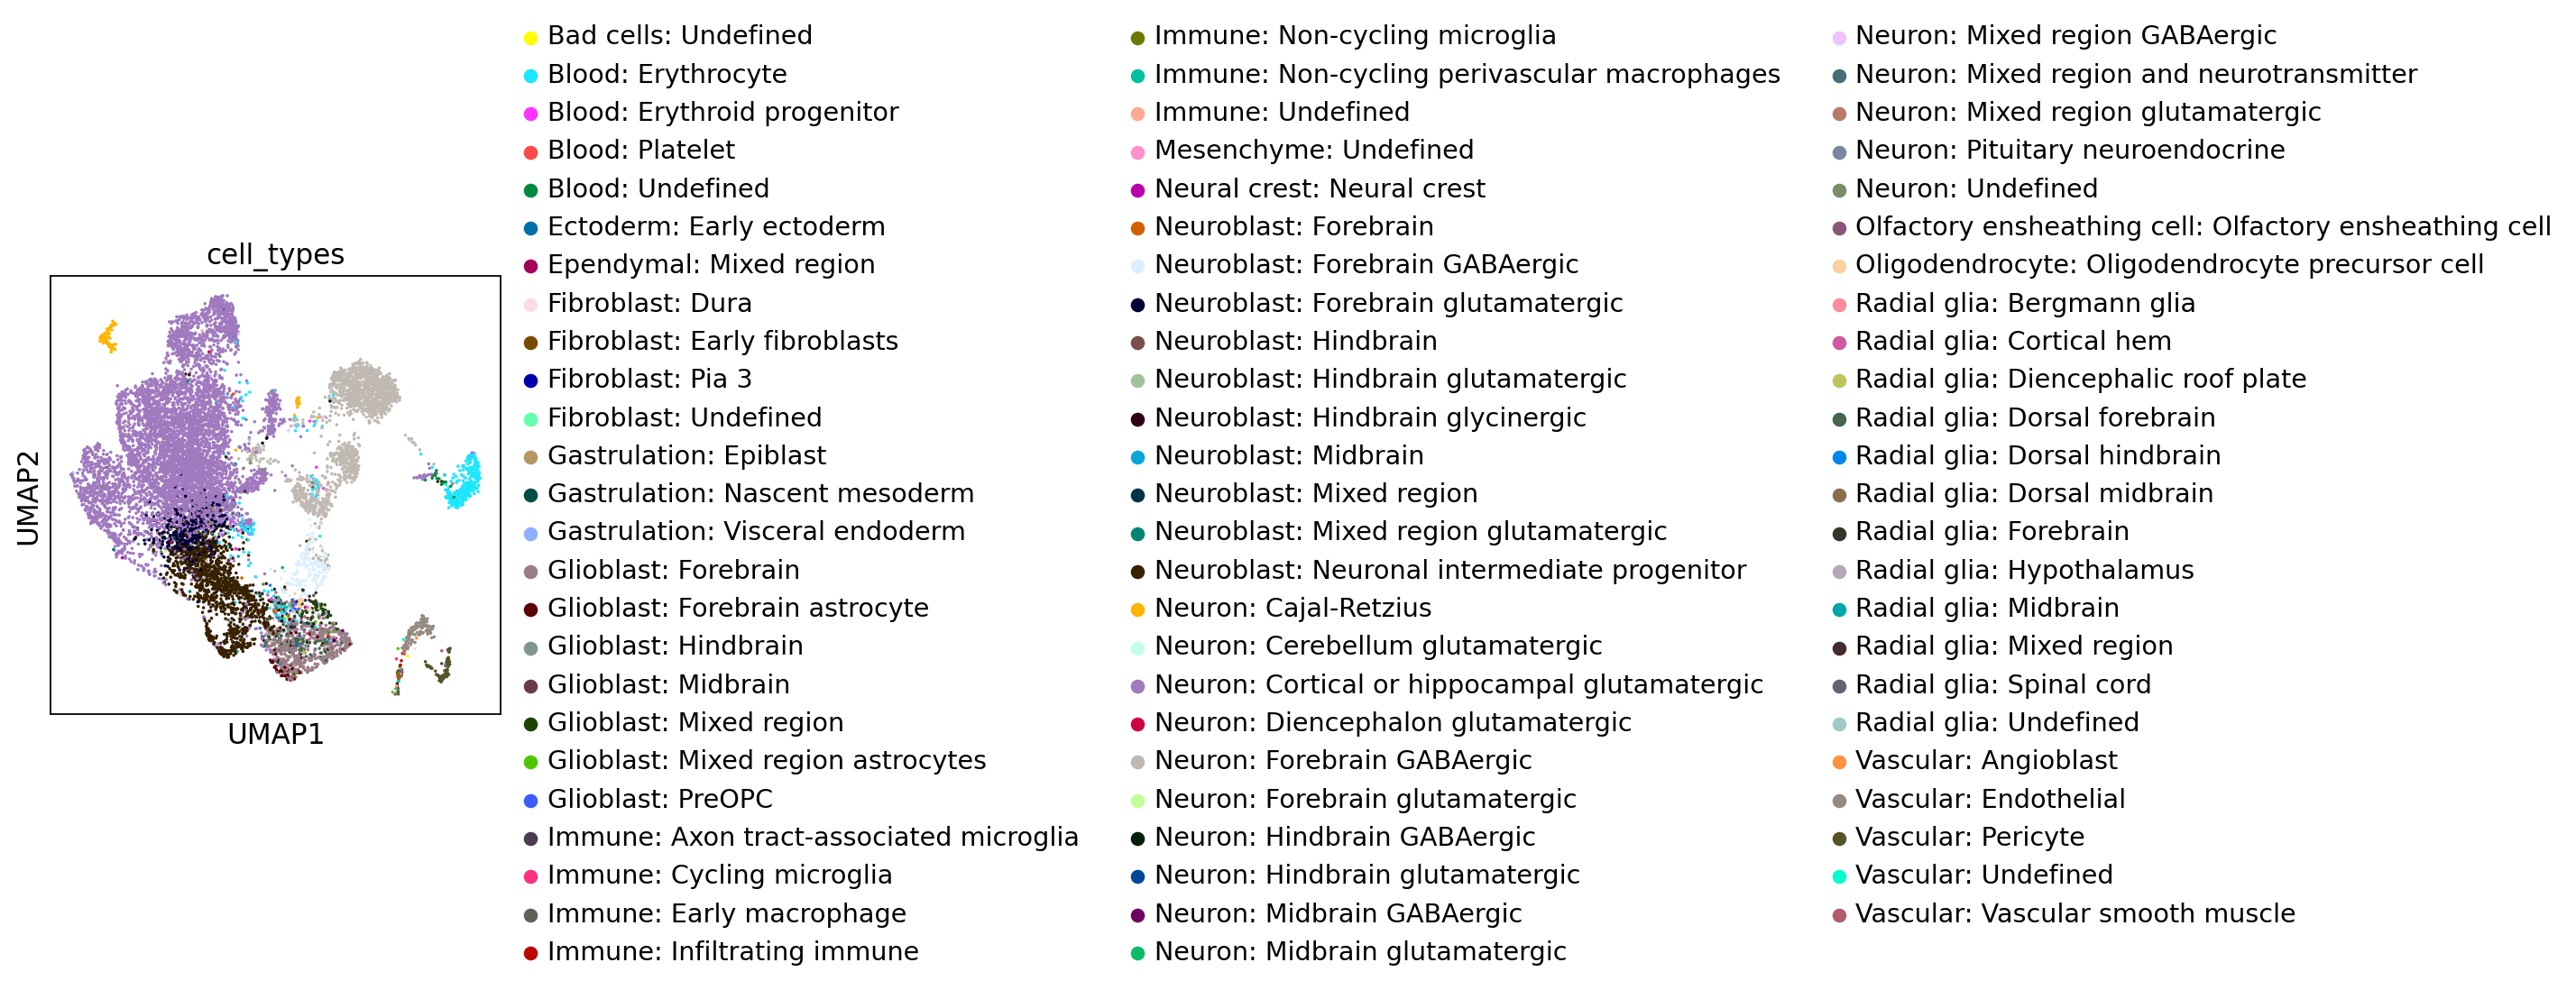

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


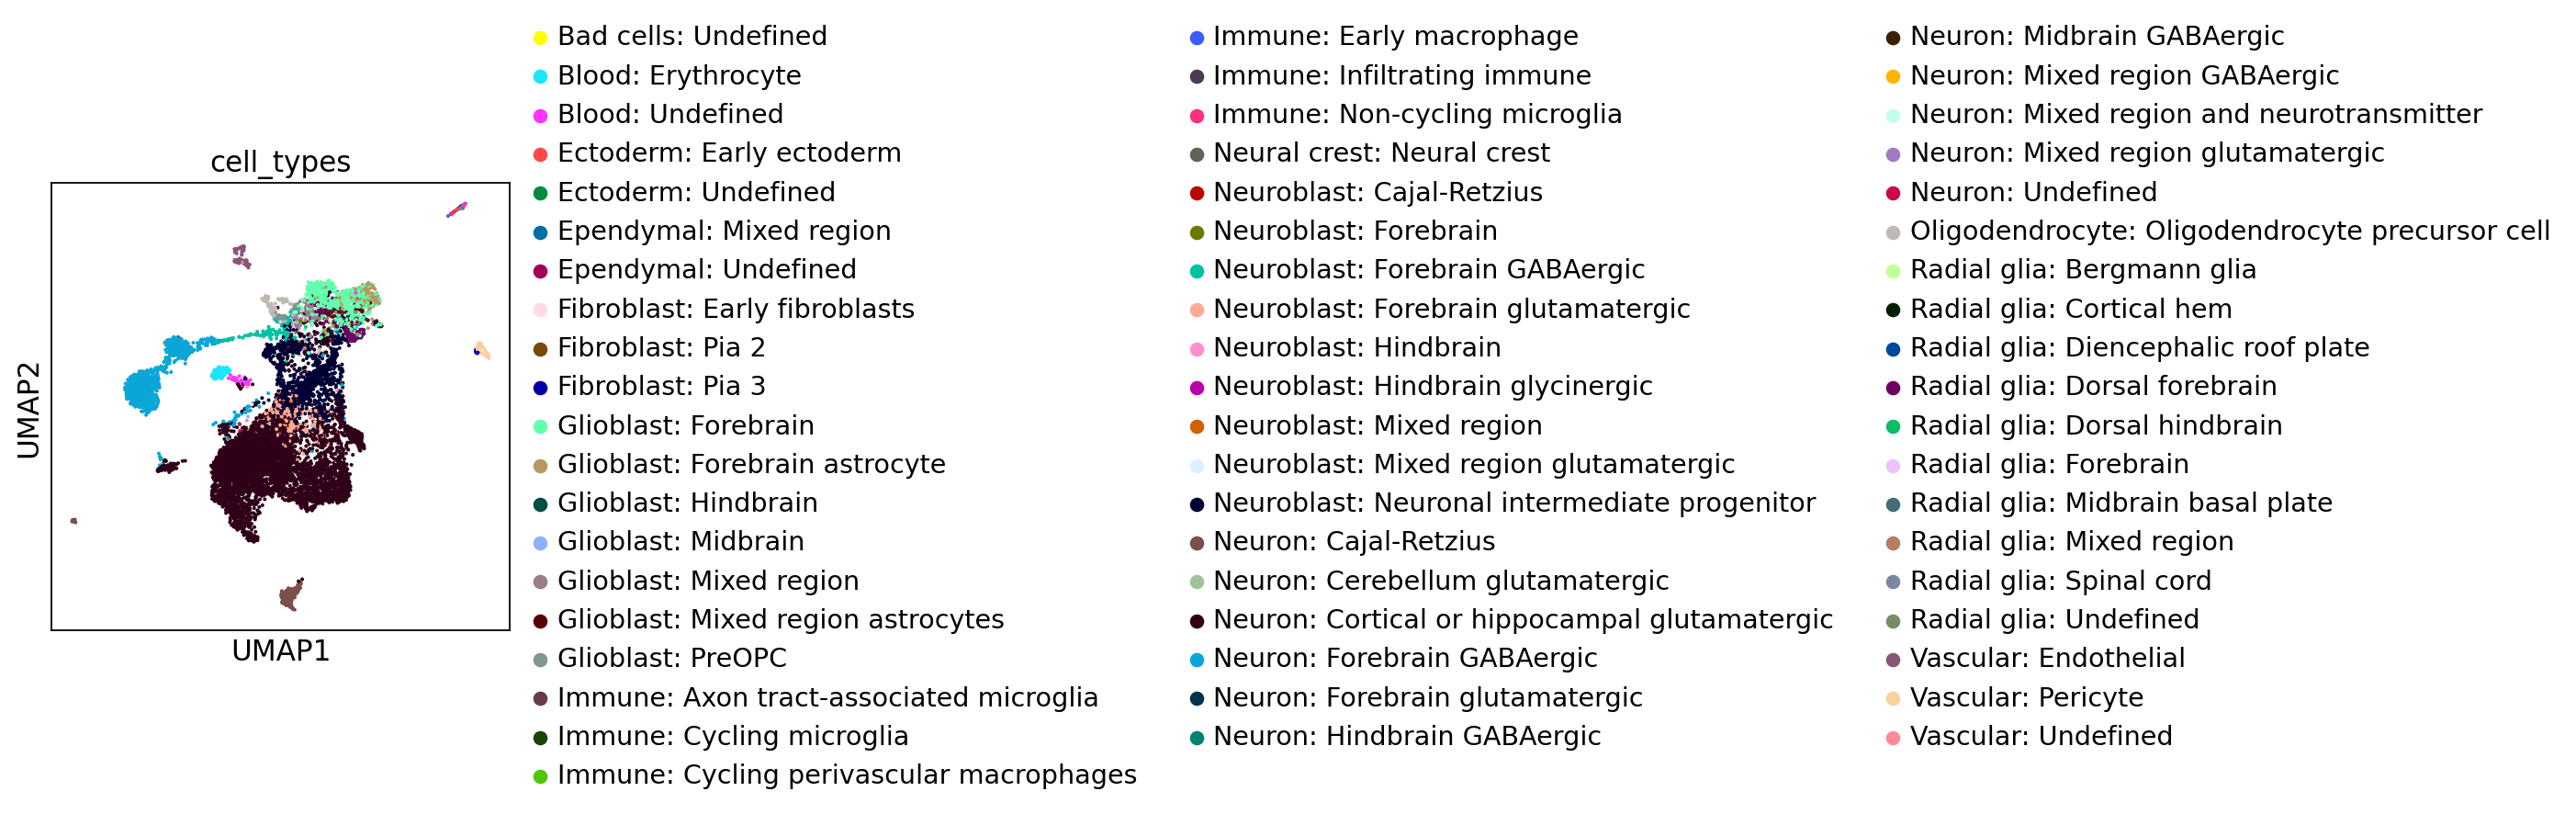

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


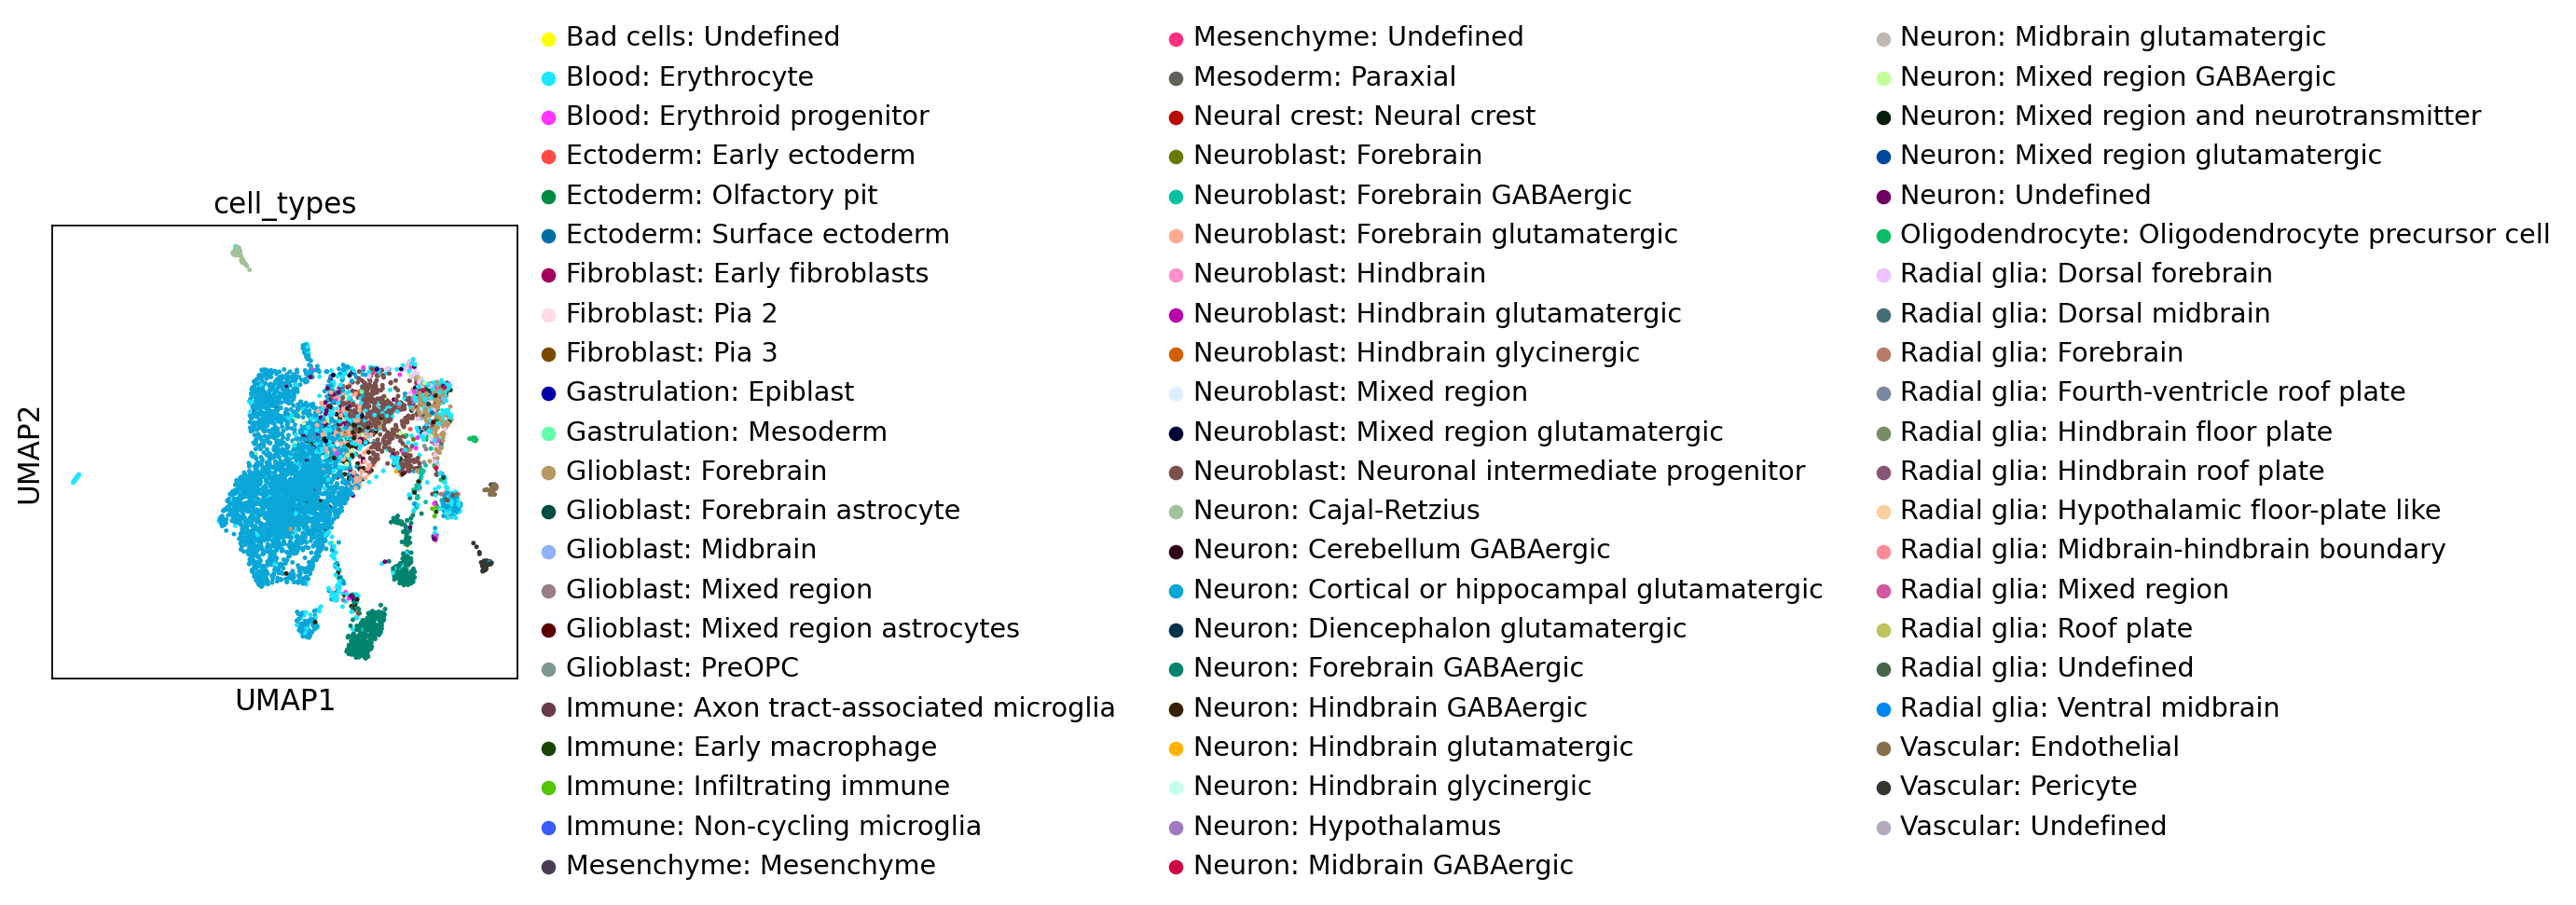

In [56]:
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    sc.tl.leiden(adata, resolution=0.5)  # Louvain clustering
    sc.pl.umap(adata, color="cell_types")

## Fixing cell mapping to be more biologically relevant and broad:

In [57]:
# Define cell types to remove (make sure "NaN" is handled correctly)
cells_to_remove = ["Blood: Undefined", "NA", "SC & Eosinophil", "NaN"]  # Remove "NaN" (not valid)
 
for i, adata in enumerate([adata_sc_bulk, adata_sc_ref, adata_sn]):    
    # Remove cells with missing or unwanted types
    adata = adata[adata.obs["cell_types"].notna() & ~adata.obs["cell_types"].isin(cells_to_remove)].copy()

    # Assign back to the original variable
    if i == 0:
        adata_sc_bulk = adata
    elif i == 1:
        adata_sc_ref = adata
    elif i == 2:
        adata_sn = adata

# Confirm that no missing values exist
print(f"SC Bulk missing cell types: {adata_sc_bulk.obs['cell_types'].isna().sum()}")
print(f"SC Ref missing cell types: {adata_sc_ref.obs['cell_types'].isna().sum()}")
print(f"SN missing cell types: {adata_sn.obs['cell_types'].isna().sum()}")

SC Bulk missing cell types: 0
SC Ref missing cell types: 0
SN missing cell types: 0


In [58]:
# Apply the mapping to the AnnData objects
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    adata.obs["cell_types"] = adata.obs["cell_types"].map(cell_type_mapping).copy()

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_types' as categorical


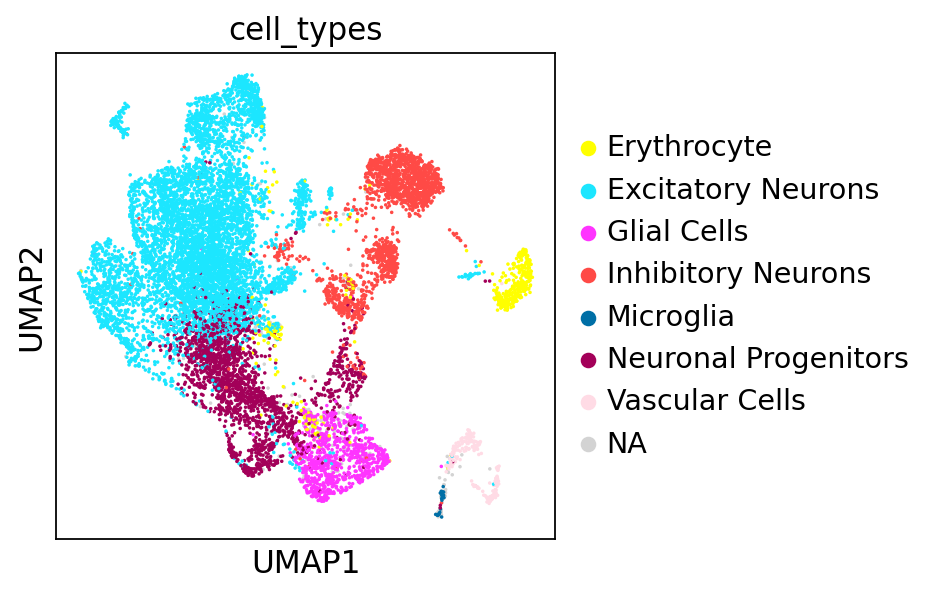

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


... storing 'cell_types' as categorical


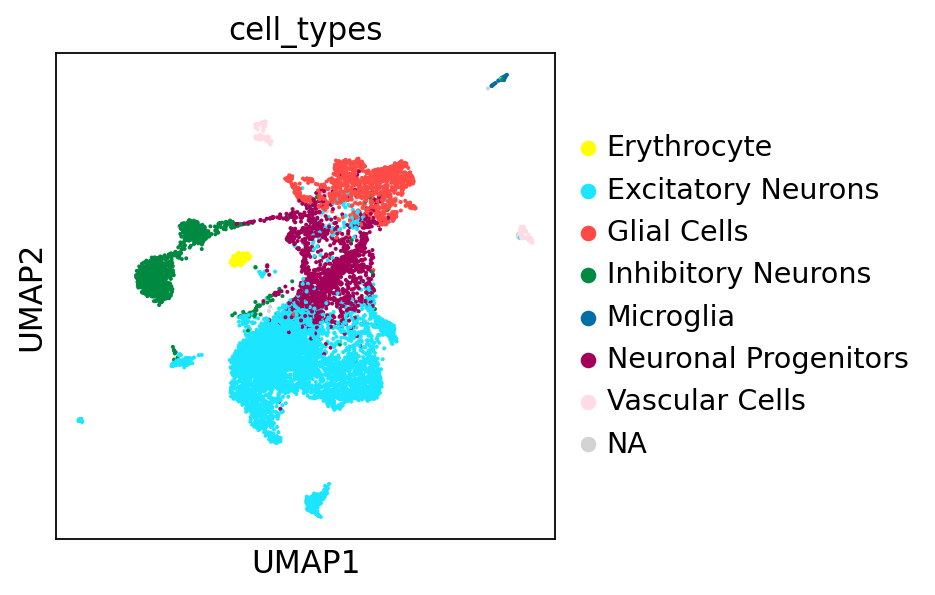

running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'cell_types' as categorical


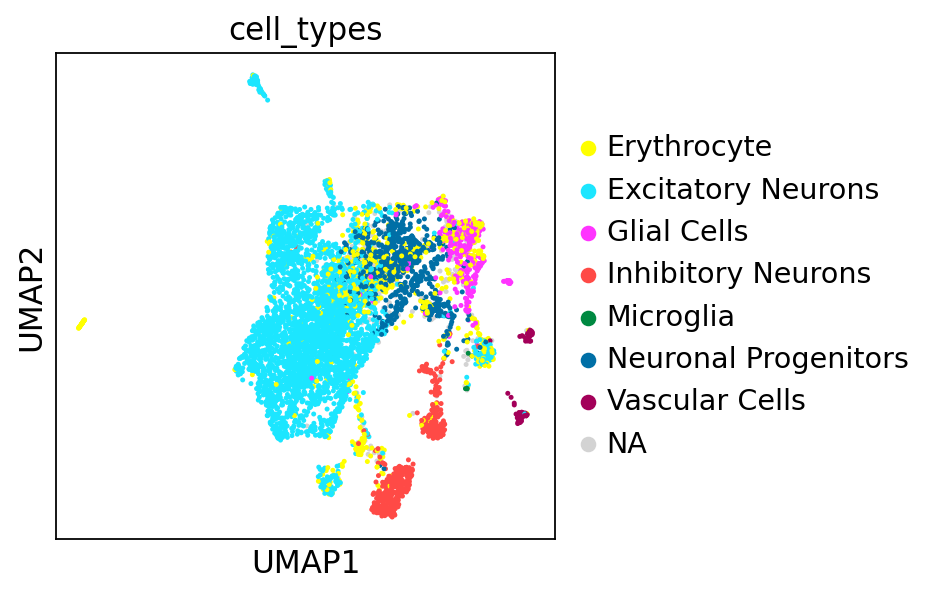

In [59]:
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    sc.tl.leiden(adata, resolution=0.5)  # liden clustering to see cells again
    sc.pl.umap(adata, color="cell_types")

In [60]:
# Restore Raw Counts Before Saving
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    print(adata)
    adata.X = adata.raw.X  # Restore original raw counts

AnnData object with n_obs × n_vars = 11827 × 31053
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_types'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
AnnData object with n_obs × n_vars = 9088 × 27998
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_types'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions

In [61]:
for adata in [adata_sc_bulk, adata_sc_ref, adata_sn]:
    print(adata)
    print(adata.obs.cell_types.value_counts())  # Restore original raw counts
    adata = adata.obs_names_make_unique()

AnnData object with n_obs × n_vars = 11827 × 31053
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'cell_types'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'over_clustering', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
cell_types
Excitatory Neurons      6459
Neuronal Progenitors    1858
Inhibitory Neurons      1720
Glial Cells              854
Erythrocyte              437
Vascular Cells           194
Microglia                 23
Name: count, dtype: int64
AnnData object with n_obs × n_vars = 9088 × 27998
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'pre

In [62]:
# Filtering the dataset that was not filtered before
if res_name == "MSB":
    adata_sn = adata_sn[adata_sn.obs.n_genes_by_counts < 7500, :]
    adata_sn = adata_sn[adata_sn.obs.pct_counts_mt < 35, :]
elif res_name == "PBMC":
    adata_sc_ref = adata_sc_ref[adata_sc_ref.obs.n_genes_by_counts < 5000, :]
    adata_sc_ref = adata_sc_ref[adata_sc_ref.obs.pct_counts_mt < 30, :]
else:
    ValueError('Not a valid data type res_name. Choose "MSB" or "PBMC"')

In [63]:
assert adata_sc_bulk.X.max() > 11
assert adata_sn.X.max() > 11
assert adata_sc_ref.X.max() > 11

In [64]:
# Save processed datasets
adata_sc_bulk.obs["deconvolution"] = "pseudobulks"
adata_sn.obs["deconvolution"] = "reference"
adata_sc_ref.obs["deconvolution"] = "reference"

adata_sc_bulk.obs["data_type"] = "single_cell"
adata_sn.obs["data_type"] = "single_nucleus"
adata_sc_ref.obs["data_type"] = "single_cell"

In [ ]:
maps={"dendritic cell": "Dendritic Cells",
        "endothelial cell": "Endothelial Cells",
        "immature NK T cell": "Immature NK T Cells",
        "monocyte": "Monocytes",
        "preadipocyte": "Preadipocytes",
        "T cell": "T Cells",
        "Endothelial cell": "Endothelial Cells",
        "T cell": "T Cells",
        "Macrophage": "Macrophages", 
        "macrophage": "Macrophages", 
        "Hepatocyte": "Hepatocytes",
        "Epithelial cell": "Epithelial Cells"}
adata_sn.obs.cell_types = adata_sn.obs.cell_types.replace(maps)
adata_sc_ref.obs.cell_types = adata_sc_ref.obs.cell_types.replace(maps)
adata_sc_bulk.obs.cell_types = adata_sc_bulk.obs.cell_types.replace(maps)

In [65]:
path = f"{os.getcwd()}/../data/{res_name}/" #Path to output
all_adatas = sc.concat([adata_sc_bulk, adata_sc_ref, adata_sn])
adata_path = os.path.join(path, f"sc_sn_{res_name}_processed.h5ad")
adata_path = Path(adata_path)
all_adatas.write_h5ad(adata_path)

... storing 'deconvolution' as categorical
... storing 'data_type' as categorical


Final QC

In [66]:
adata_sc_ref.obs.cell_types.value_counts()

cell_types
Excitatory Neurons      4769
Neuronal Progenitors    1618
Inhibitory Neurons      1197
Glial Cells             1092
Vascular Cells           139
Erythrocyte               94
Microglia                 28
Name: count, dtype: int64

In [67]:
adata_sc_bulk.obs.cell_types.value_counts()

cell_types
Excitatory Neurons      6459
Neuronal Progenitors    1858
Inhibitory Neurons      1720
Glial Cells              854
Erythrocyte              437
Vascular Cells           194
Microglia                 23
Name: count, dtype: int64

In [68]:
adata_sn.obs.cell_types.value_counts()

cell_types
Excitatory Neurons      3232
Neuronal Progenitors     710
Erythrocyte              619
Inhibitory Neurons       474
Glial Cells              286
Vascular Cells            75
Microglia                  6
Name: count, dtype: int64